In [1]:
#%% Imports
import os
import numpy as np
import spectral
import matplotlib.pyplot as plt
from skimage import exposure, io

from scipy import stats
from sklearn.linear_model import LinearRegression

# Import "local" packages
import hyspec_io, image_render, preprocess, misc 

In [2]:
import importlib
importlib.reload(preprocess)

<module 'preprocess' from '/home/mha114/Dropbox/Python/massimal/tools/preprocess.py'>

In [3]:
#%% Paths
train_raw_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Raw/OlbergholmenS-21/OlbergholmenS_Pika_L_21.bil.hdr'
train_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance/OlbergholmenS_Pika_L_21-Radiance From Raw Data.bip.hdr'
test_file = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/Radiance/OlbergholmenS_Pika_L_17-Radiance From Raw Data.bip.hdr'
output_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/Test_Deglint'

In [4]:
#%% Import data
(im_train_raw,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(train_raw_file)
(im_train,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(train_file)
(im_test,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(test_file)

In [5]:
im_test.dtype

dtype('float32')

In [6]:
#%% Detect saturated pixels in training data
sat_pix_mask = preprocess.detect_saturated(im_train_raw)
print('Number of saturated pixels: ' + str(np.count_nonzero(sat_pix_mask)))

Number of saturated pixels: 66


In [7]:
spec_train = im_train[~sat_pix_mask]
spec_train.shape

(959334, 300)

In [8]:
#%% Create Hedley sun glint correction object
sgc = preprocess.HedleySunGlint()
sgc.fit(spec_train,wl)

In [9]:
im_test_sgc = sgc.remove_glint(im_test)

In [10]:
im_test_sgc.shape

(2000, 900, 173)

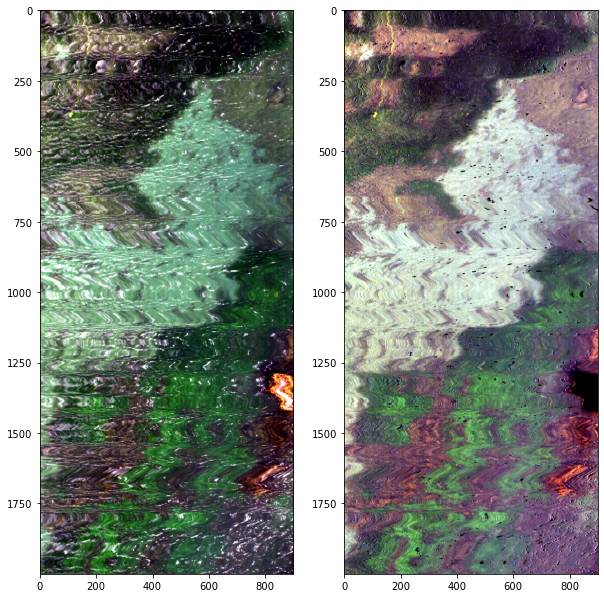

In [11]:
#%% Show original and glint corrected image
fig,ax = plt.subplots(ncols=2,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im_test[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_test_sgc[:,:,rgb_ind]))

In [12]:
print('Number of negative pixels: ' + str(np.count_nonzero(im_test_sgc<0)/im_test_sgc.size))
#spectral.envi.save_image(output_file,im_cube_inpaint,dtype='uint16',metadata=metadata,force=True)

Number of negative pixels: 0.0


In [13]:
save_file_path = misc.build_newdir_filepath([test_file],output_dir)
print(save_file_path)

['/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/Test_Deglint/OlbergholmenS_Pika_L_17-Radiance From Raw Data.bip.hdr']


In [14]:
im_test_sgc[im_test_sgc<0] = 0

In [15]:
print('Number of negative pixels: ' + str(np.count_nonzero(im_test_sgc<0)))

Number of negative pixels: 0


In [16]:
metadata['wavelength'] = [metadata['wavelength'][ii] for ii in range(len(wl)) if sgc.vis_ind[ii]]

In [17]:
metadata['wavelength']

['390.86',
 '392.87',
 '394.88',
 '396.89',
 '398.9',
 '400.91',
 '402.92',
 '404.93',
 '406.94',
 '408.96',
 '410.97',
 '412.99',
 '415.0',
 '417.02',
 '419.04',
 '421.06',
 '423.08',
 '425.1',
 '427.12',
 '429.14',
 '431.17',
 '433.19',
 '435.22',
 '437.24',
 '439.27',
 '441.3',
 '443.33',
 '445.36',
 '447.39',
 '449.42',
 '451.45',
 '453.49',
 '455.52',
 '457.56',
 '459.59',
 '461.63',
 '463.67',
 '465.71',
 '467.75',
 '469.79',
 '471.83',
 '473.87',
 '475.91',
 '477.96',
 '480.0',
 '482.05',
 '484.1',
 '486.14',
 '488.19',
 '490.24',
 '492.29',
 '494.34',
 '496.39',
 '498.45',
 '500.5',
 '502.56',
 '504.61',
 '506.67',
 '508.73',
 '510.79',
 '512.84',
 '514.9',
 '516.97',
 '519.03',
 '521.09',
 '523.15',
 '525.22',
 '527.29',
 '529.35',
 '531.42',
 '533.49',
 '535.56',
 '537.63',
 '539.7',
 '541.77',
 '543.84',
 '545.92',
 '547.99',
 '550.07',
 '552.14',
 '554.22',
 '556.3',
 '558.38',
 '560.46',
 '562.54',
 '564.62',
 '566.7',
 '568.78',
 '570.87',
 '572.95',
 '575.04',
 '577.13',

In [18]:
#spectral.envi.save_image(save_file_path[0],im_test_sgc,dtype='uint16',metadata=metadata,force=True,ext=None)

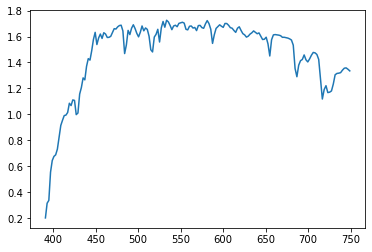

In [20]:
plt.plot(sgc.wl[sgc.vis_ind],np.squeeze(sgc.b))

In [28]:
zeros_fraction = np.count_nonzero(im_test_sgc == 0, axis=2) / im_test_sgc.shape[2]

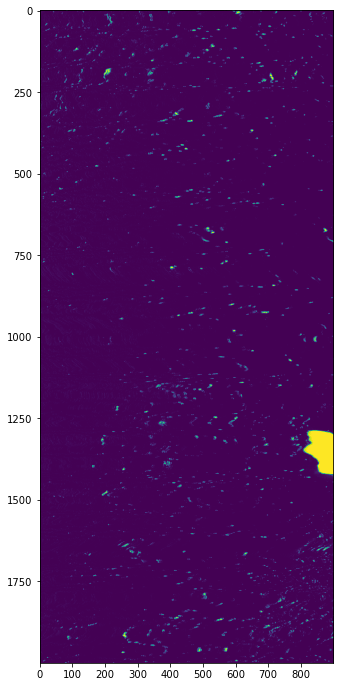

In [29]:
fig,ax = plt.subplots(ncols=1,figsize=(6,12))
ax.imshow(zeros_fraction)

In [40]:
zeros_mask = zeros_fraction > 0.10

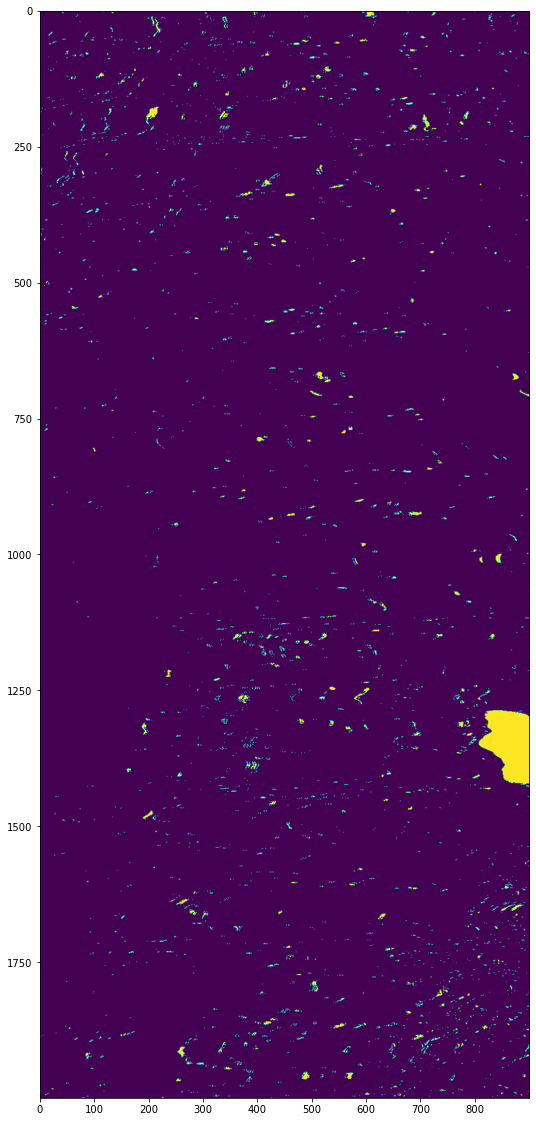

In [39]:
fig,ax = plt.subplots(ncols=1,figsize=(10,20))
ax.imshow(zeros_mask,interpolation=None)

In [41]:
tmp = np.copy(im_test_sgc)

In [42]:
tmp[zeros_mask] = 0

In [43]:
tmp.shape

(2000, 900, 173)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


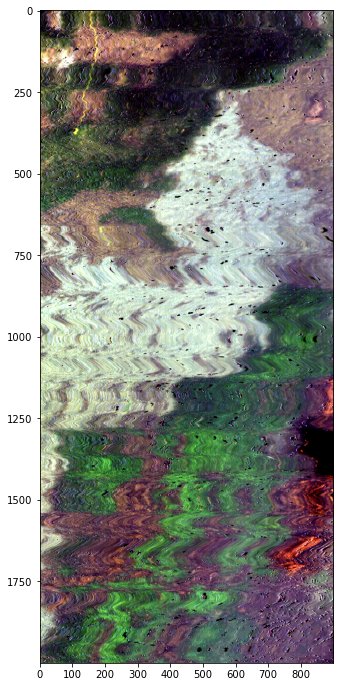

In [45]:
fig,ax = plt.subplots(ncols=1,figsize=(6,12))
ax.imshow(image_render.percentile_stretch(tmp[:,:,rgb_ind],percentiles=(4,98)))